# Surface concentrations

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date

%matplotlib inline

###### Parameters:

In [5]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

land_color = '#8b7765'

# model results:
year = 2015

# base_old    = '/data/brogalla/run_storage/Mn-reference-202103/spin-up0-202103/'
base_old    = '/data/brogalla/run_storage/Mn-reference-202103/ref-2015-202103/'
# base_tuning = '/data/brogalla/run_storage/mn-reference-test-spin-up0-202105/'
base_tuning = '/data/brogalla/run_storage/ANHA12_ref-2015_20210630/'

###### Load files:

In [6]:
ref   = nc.Dataset(f'{base_old}ANHA12_EXH006_{year}_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [7]:
results_00  = nc.Dataset(f'{base_old}ANHA12_EXH006_{year}_monthly.nc')
dissolmn_old0 = np.array(results_00.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn_old0 = np.array(results_00.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units
results_00.close()

In [8]:
results_10  = nc.Dataset(f'{base_tuning}ANHA12_EXH006_{year}_monthly.nc')
dissolmn_10 = np.array(results_10.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn_10 = np.array(results_10.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units
results_10.close()

In [9]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

##### Functions:

In [10]:
def plot_experiment(ax, variable, month=0, layer=0, vmin=0, vmax=7, cmap=cmocean.cm.dense):
    proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax)
    proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    x, y = proj1(lons, lats)
    
    var = np.ma.masked_where(tmask[layer,:,:] < 0.1, variable[month,layer,:,:])
    
    c1 = proj1.contourf(x, y, var, np.arange(vmin,vmax+1,0.25),\
                             cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
    
    return c1

In [20]:
def plot_comparison(month=0, layer=0, ox=False):
    
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    
    if ox:
        fig.suptitle(f'Oxidised Mn for month index {month}, depth layer {layer}', fontsize=14)
        # Panel A & B: 
        c1 = plot_experiment(ax[0], oxidismn_old0, vmax=12, month=month, layer=layer)
        c2 = plot_experiment(ax[1], oxidismn_10  , vmax=12, month=month, layer=layer)
        c3 = plot_experiment(ax[2], oxidismn_10-oxidismn_old0, vmin=-4, vmax=4, cmap=cmocean.cm.balance, month=month, layer=layer)        
    else:
        fig.suptitle(f'Dissolved Mn for month index {month}, depth layer {layer}', fontsize=14)
        # Panel A & B: 
        c1 = plot_experiment(ax[0], dissolmn_old0, vmax=15, month=month, layer=layer)
        c2 = plot_experiment(ax[1], dissolmn_10  , vmax=15, month=month, layer=layer)
        c3 = plot_experiment(ax[2], dissolmn_10-dissolmn_old0, vmin=-4, vmax=4, cmap=cmocean.cm.balance, month=month, layer=layer)
    
    ax[0].set_title('Reference exp (Mn-reference-202103)', fontsize=12)
    ax[1].set_title('Sinking fixed', fontsize=12)
    ax[2].set_title('Difference', fontsize=12)

    cbar_ax1 = fig.add_axes([0.13, 0.15, 0.02, 0.25])
    cbar_ax2 = fig.add_axes([0.41, 0.15, 0.02, 0.25])
    cbar_ax3 = fig.add_axes([0.68, 0.15, 0.02, 0.25])
    cbar1    = fig.colorbar(c1, cax=cbar_ax1, ticks=np.arange(0,14,4))
    cbar2    = fig.colorbar(c2, cax=cbar_ax2, ticks=np.arange(0,14,4))
    cbar3    = fig.colorbar(c3, cax=cbar_ax3, ticks=np.linspace(-4,4,5))

    return

### Profiles:

In [12]:
# Average over a region in central Canada Basin
month=7
i  = 608
j  = 418
di = 30
dj = 30

dmn_old = dissolmn_old0[month,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))
dmn_new = dissolmn_10[month,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))
omn_old = oxidismn_old0[month,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))
omn_new = oxidismn_10[month,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))

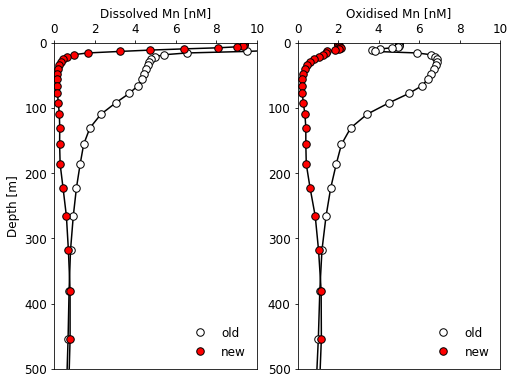

In [15]:
fig, ax = plt.subplots(1,2, figsize=(8,6))
    
ax[0].set_title('Dissolved Mn [nM]', fontsize=12)
ax[0].plot(dmn_old, depth, '-k')
ax[0].plot(dmn_old, depth, '.w', markersize=15, markeredgecolor='k', label='old')
ax[0].plot(dmn_new, depth, '-k')
ax[0].plot(dmn_new, depth, '.r', markersize=15, markeredgecolor='k', label='new')

ax[1].set_title('Oxidised Mn [nM]', fontsize=12)
ax[1].plot(omn_old, depth, '-k')
ax[1].plot(omn_old, depth, '.w', markersize=15, markeredgecolor='k', label='old')
ax[1].plot(omn_new, depth, '-k')
ax[1].plot(omn_new, depth, '.r', markersize=15, markeredgecolor='k', label='new')

ax[0].set_ylabel('Depth [m]', fontsize=12)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_xlim(0,10)
    axis.set_ylim(500,0)
    axis.tick_params(axis='both', labelsize=12)
    axis.xaxis.tick_top()    
    axis.xaxis.set_label_position('top') 
    axis.legend(fontsize=12, frameon=False, loc=4)

### Do I exactly reproduce the surface fields in my recreated reference run (which doesn't have sinking)?

In [96]:
recreated_ref = '/data/brogalla/run_storage/mn-reference-nosink-spin-up0-202105/'

results_rec  = nc.Dataset(f'{recreated_ref}ANHA12_EXH006_{year}_monthly.nc')
dissolmn_rec = np.array(results_rec.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn_rec = np.array(results_rec.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units
results_rec.close()

In [100]:
print(np.array_equal(dissolmn_rec, dissolmn_old0))
print(np.array_equal(oxidismn_rec, oxidismn_old0))

True
True


### dissolved Mn concentrations:

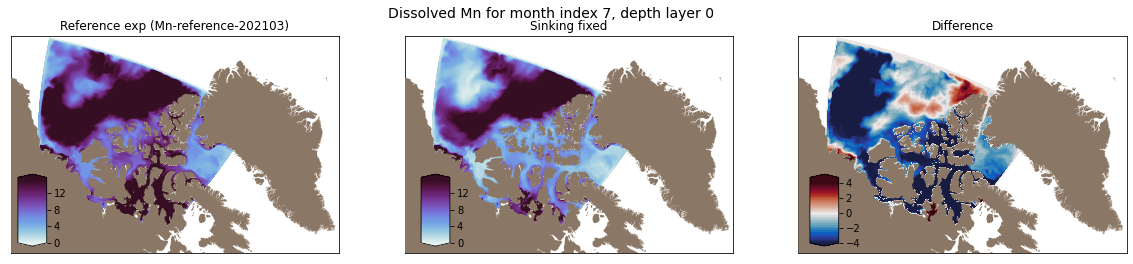

In [22]:
plot_comparison(month=7,layer=0)

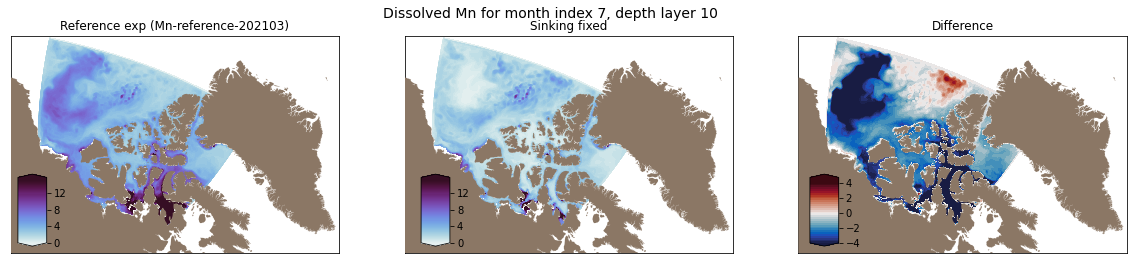

In [23]:
plot_comparison(month=7,layer=10)

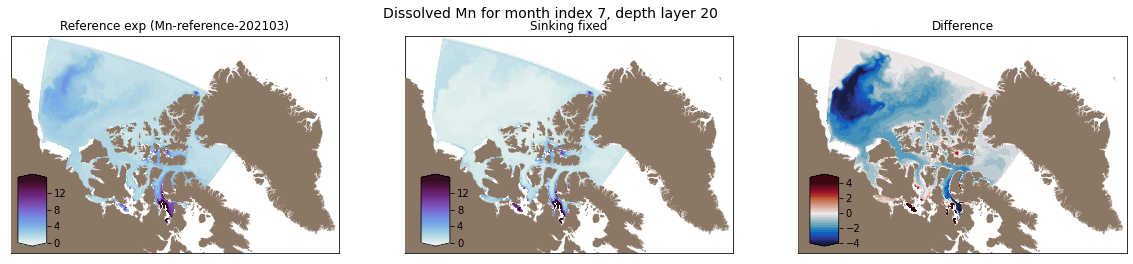

In [24]:
plot_comparison(month=7,layer=20)

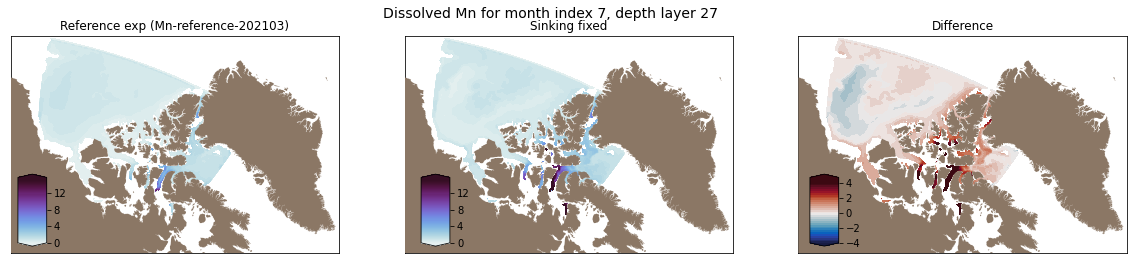

In [25]:
plot_comparison(month=7,layer=27)

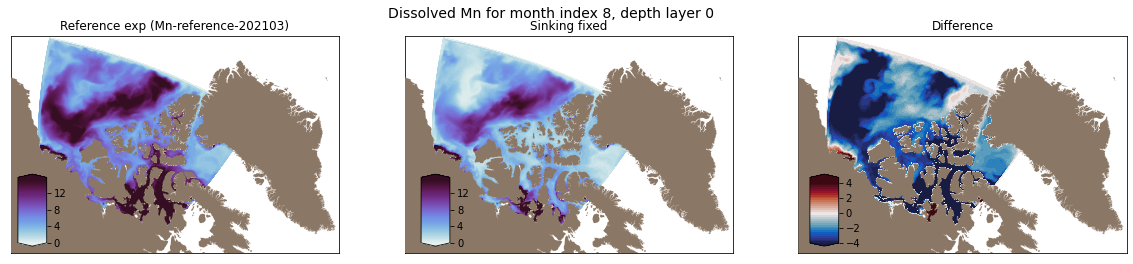

In [26]:
plot_comparison(month=8,layer=0)

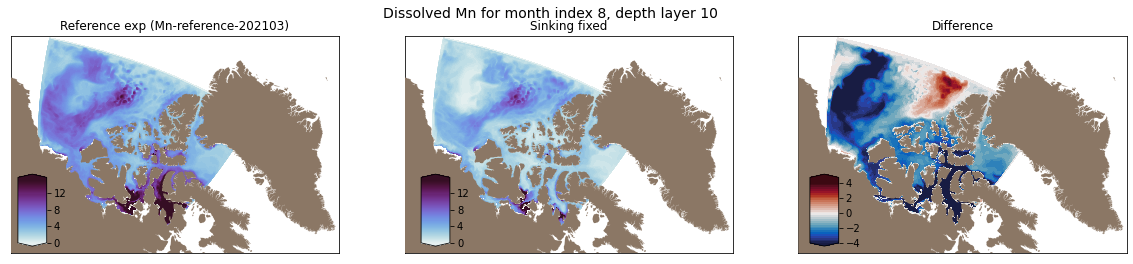

In [27]:
plot_comparison(month=8,layer=10)

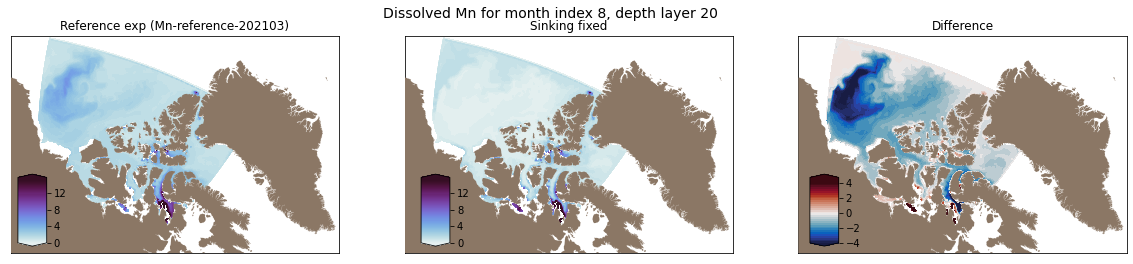

In [28]:
plot_comparison(month=8,layer=20)

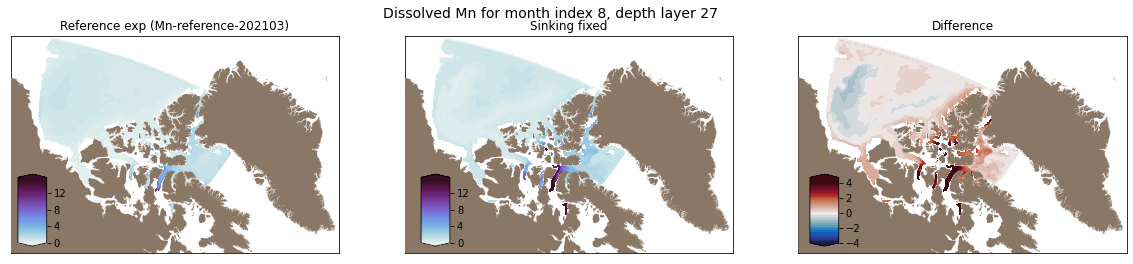

In [29]:
plot_comparison(month=8,layer=27)

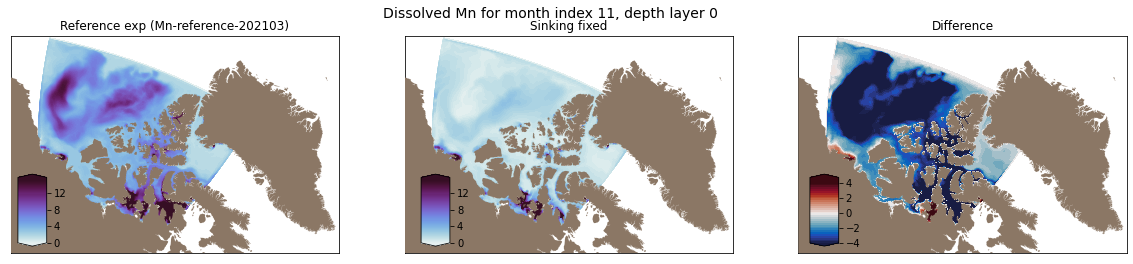

In [30]:
plot_comparison(month=11,layer=0)

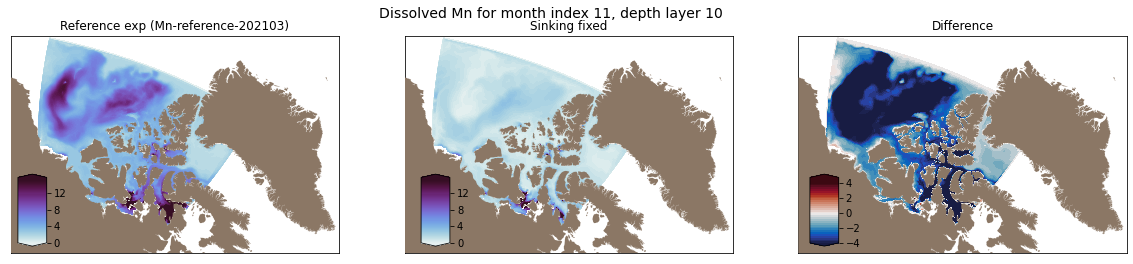

In [31]:
plot_comparison(month=11,layer=10)

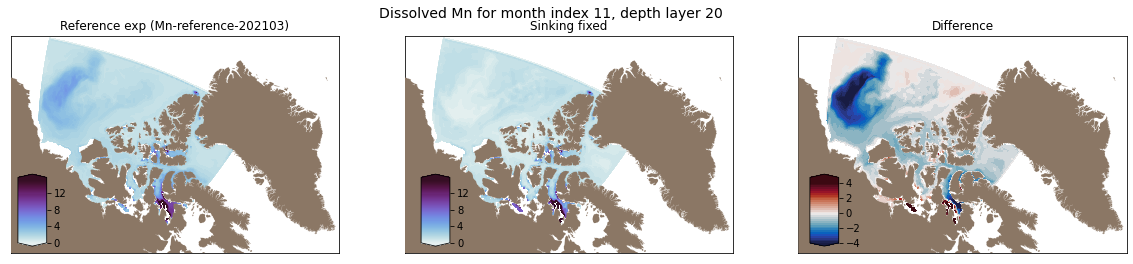

In [32]:
plot_comparison(month=11,layer=20)

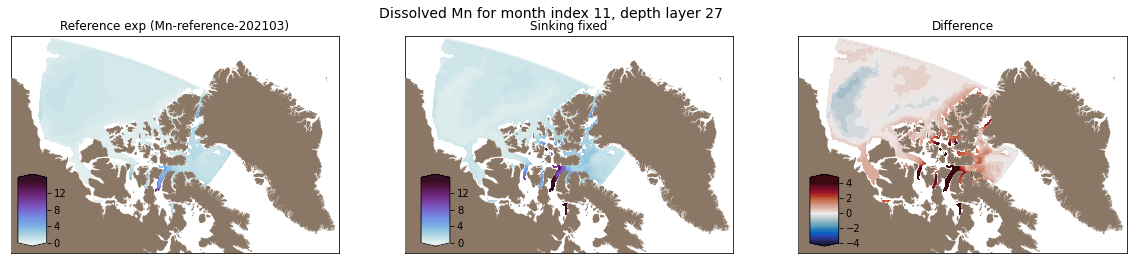

In [33]:
plot_comparison(month=11,layer=27)

### oxidised Mn concentrations:

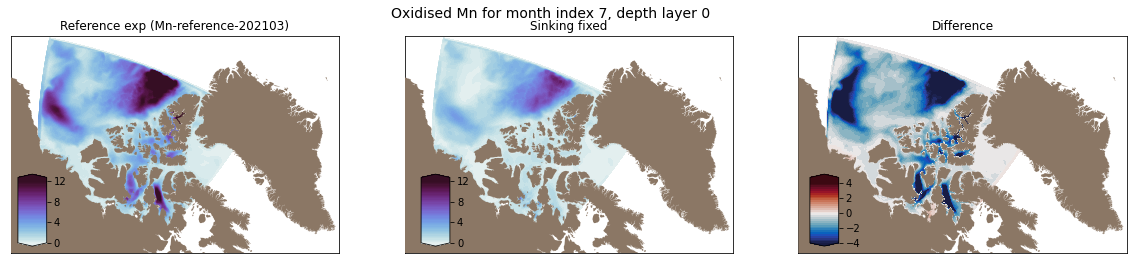

In [34]:
plot_comparison(month=7,layer=0, ox=True)

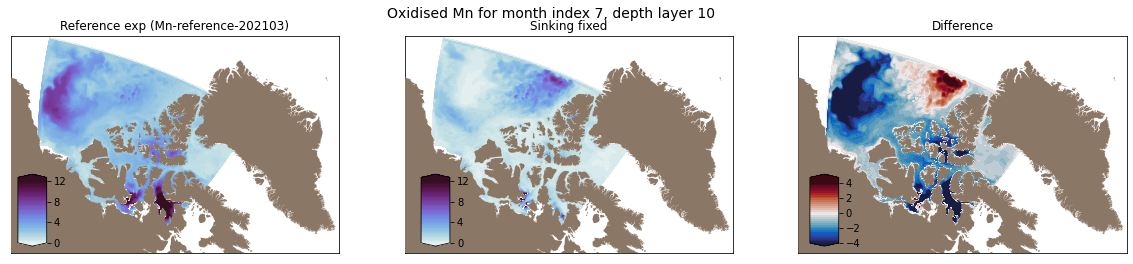

In [35]:
plot_comparison(month=7,layer=10, ox=True)

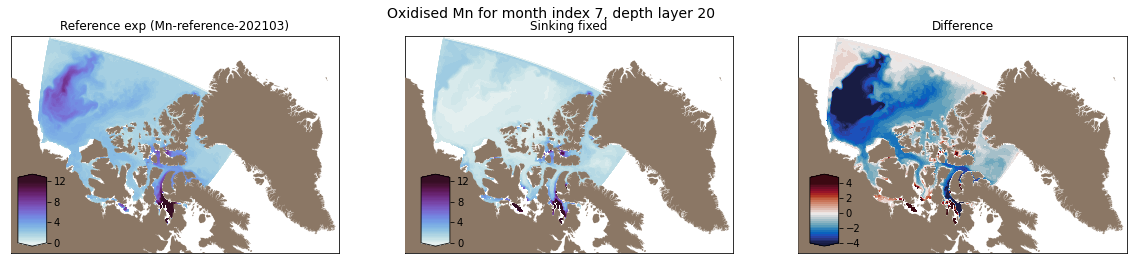

In [36]:
plot_comparison(month=7,layer=20, ox=True)

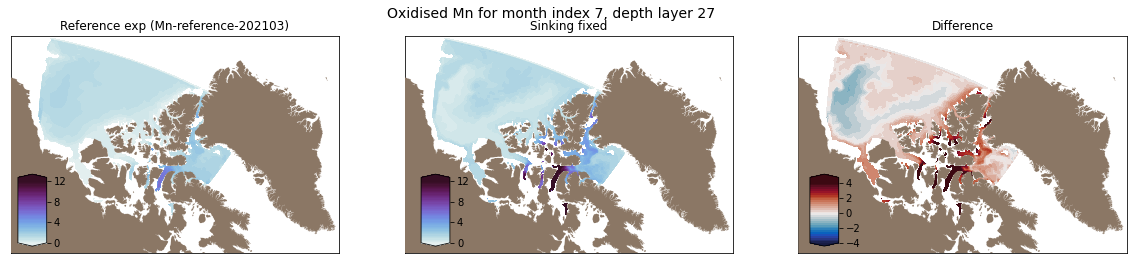

In [37]:
plot_comparison(month=7,layer=27, ox=True)

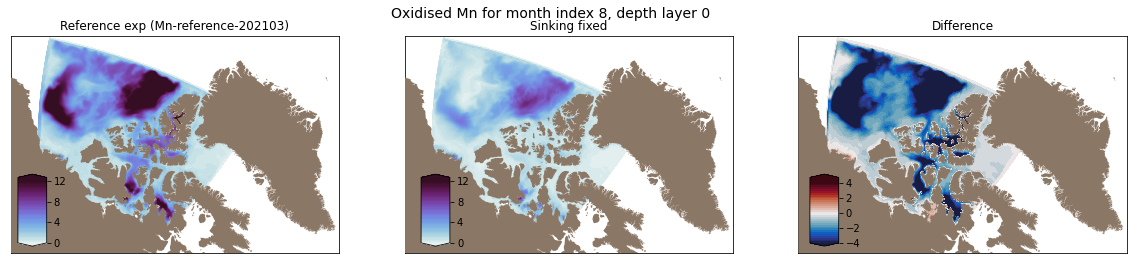

In [38]:
plot_comparison(month=8,layer=0, ox=True)

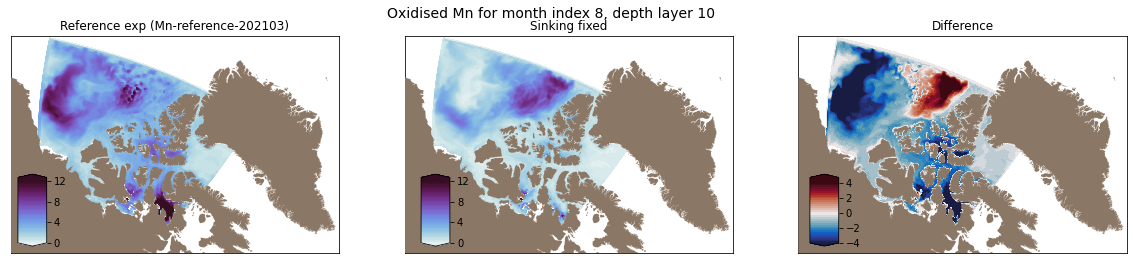

In [39]:
plot_comparison(month=8,layer=10, ox=True)

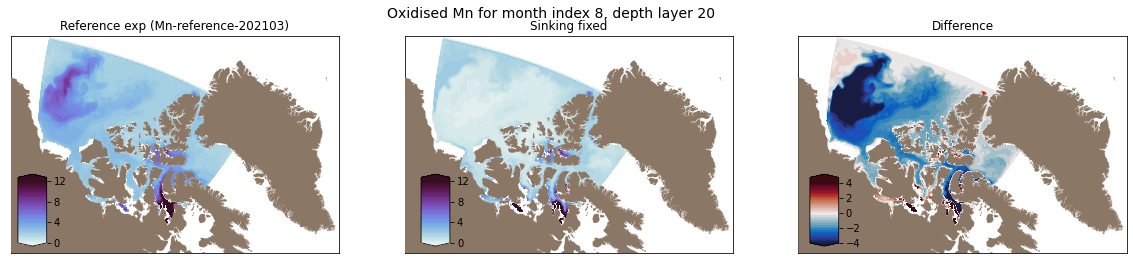

In [40]:
plot_comparison(month=8,layer=20, ox=True)

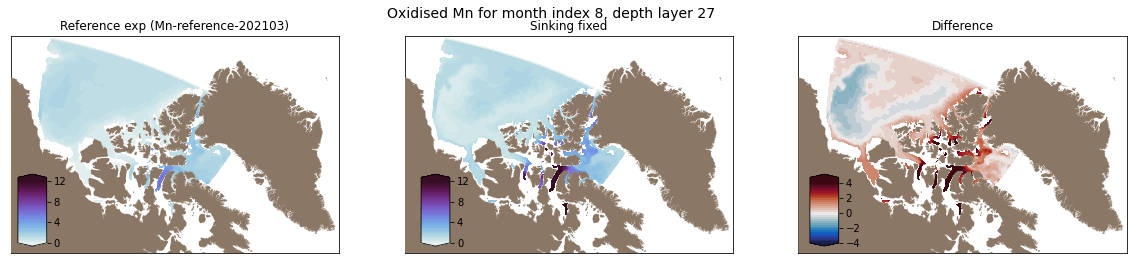

In [41]:
plot_comparison(month=8,layer=27, ox=True)

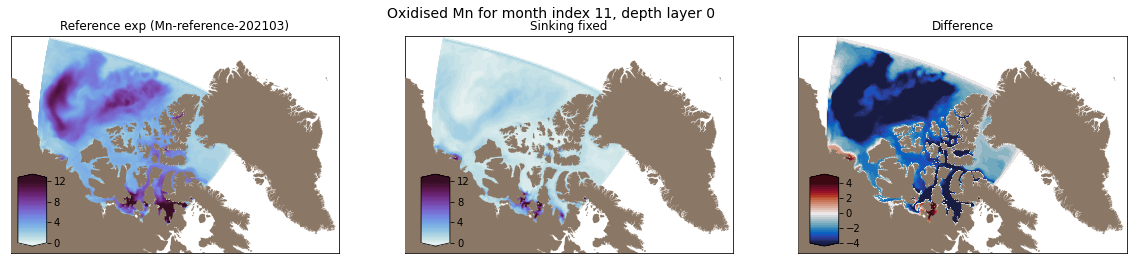

In [42]:
plot_comparison(month=11,layer=0, ox=True)

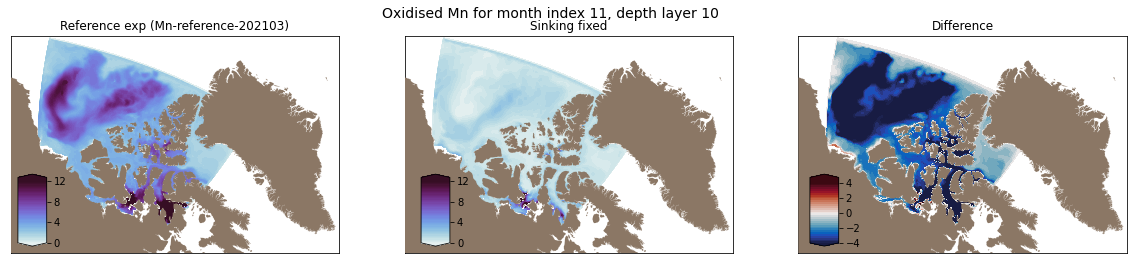

In [43]:
plot_comparison(month=11,layer=10, ox=True)

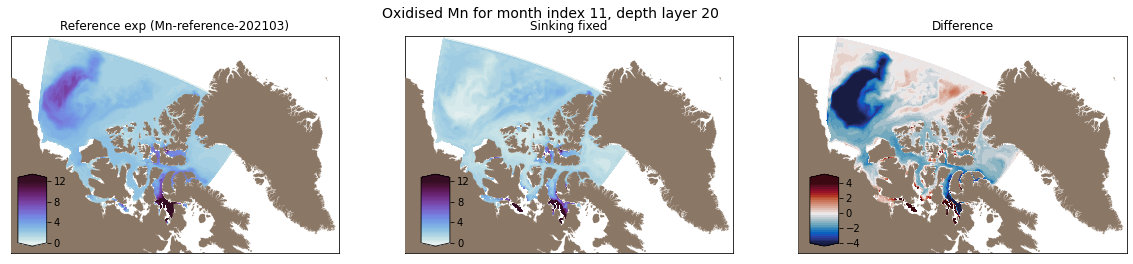

In [44]:
plot_comparison(month=11,layer=20, ox=True)

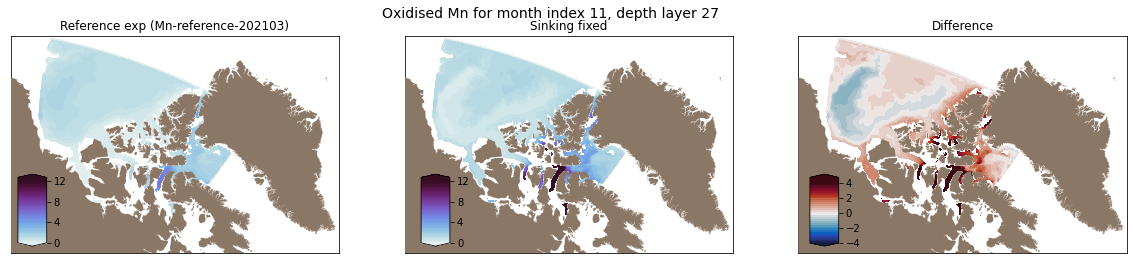

In [45]:
plot_comparison(month=11,layer=27, ox=True)